In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotting as plot
import itertools

import recon
model = recon.recon.Recon()
util = recon.utilities.Utilities()

# sns.set_style('white')
sns.set_style('ticks')

## UC analyses

In [17]:
# Proteomics data
proteomics = pd.read_csv('../../../reporter_metabolites/mapped_proteomics.csv', index_col='number')
proteomics.index = proteomics.index.astype('str')

# Predicted centrality
pr = pd.read_csv('../../data/UC_analyses/pr_centrality_proteomics_158p.csv', sep='\t', index_col=0)
# pr = pd.read_csv('../../data/UC/pr_centrality_Schniers2019.csv', index_col=0)
pr['vmh'] = [i[:-3].lower() for i in pr.index]
pr['mets'] = [i for i in pr.index]

# Metabolomics data
metabolomics = pd.read_csv('../../../reporter_metabolites/mapped_metabolomics_curated.csv', sep=',')
metabolomics.vmh = metabolomics.vmh.str.lower()
for col in metabolomics.columns.difference(['vmh', ]):
    metabolomics.loc[:, col] = metabolomics.loc[:, col].astype(float)
metabolomics.head()

,vmh,A,C,p,padj,fc
0,1agpe180,0.016223,0.024622,0.065422,0.143757,0.658893
1,2hxic_l,0.000584,0.000800,0.458849,0.589444,0.730002
2,3hexdcrn,0.000448,0.000180,0.000509,0.005003,2.487959
3,3ivcrn,0.002000,0.001164,0.004654,0.025910,1.718587
4,3octdece1crn,0.001305,0.000460,0.001328,0.009641,2.835666


In [18]:
len(metabolomics)
# p_crit = metabolomics.p < .05
# fc_crit = (metabolomics.fc > 1.2) | (metabolomics.fc < .8) 
# metabolomics = metabolomics[p_crit & fc_crit]
# len(metabolomics)

143

In [19]:
cc = util.calculate_cc(g_df=proteomics)
# cc_m = util.calculate_cc(g_df=proteomics, grouping='mitochondrial')
# cc_c = util.calculate_cc(g_df=proteomics, grouping='cytoplasm')

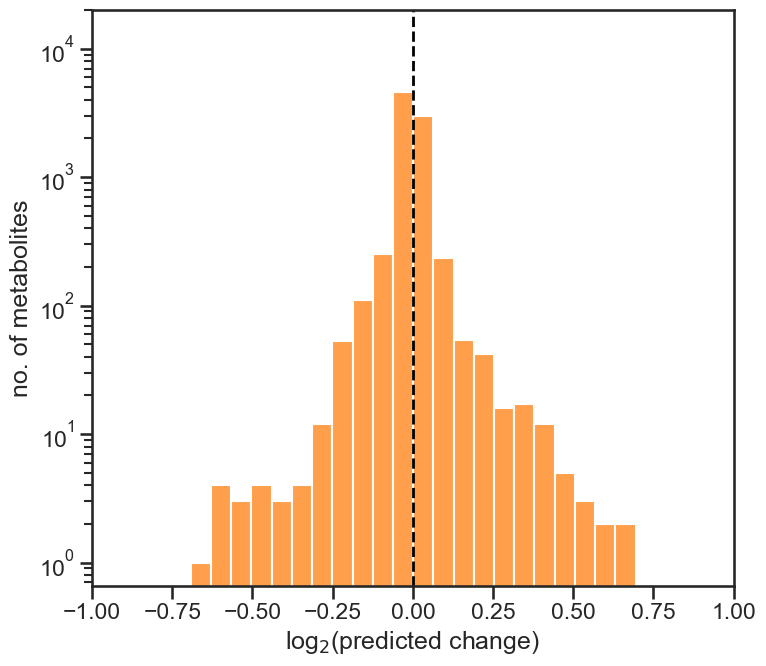

In [5]:
sns.set_context("talk")

plot.hist(pr=np.log2(pr.mean(axis=1)), 
          save=True, filename='../../images/UC/histplot_uc_patients_proteomics_1.svg', 
          figsize=(8,7), xlim=(-1., 1.), bins=22, color='C1', ylim=(0, 2e4),
          xlabel='log$_2$(predicted change)', ylabel='no. of metabolites')

In [6]:
def map_metabolomics(metabolomics, pr):
    print(f'mapped: {len(set([i.lower() for i in metabolomics.vmh]) & set([i.lower() for i in pr.vmh]))}')
    print(f'missing: {len(set([i.lower() for i in metabolomics.vmh]) - set([i.lower() for i in pr.vmh]))}')
    missing = list(set([i.lower() for i in metabolomics.vmh]) - set([i.lower() for i in pr.vmh]))
    print(f'\t{missing}')
    m1 = pr.merge(metabolomics, left_on='vmh', right_on='vmh').set_index('mets')
    m2 = util.reshape(m1, include=None)
    m2 = m2.rename(columns={'0': 'prediction_proteomics', 0: 'prediction_proteomics', 'fc': 'metabolomics'})
    m2['p'] = m2['p'].astype('float')
    m2['metabolomics'] = m2['metabolomics'].astype('float')
    m2['prediction_proteomics'] = m2['prediction_proteomics'].astype('float')
    return m2

In [20]:
met = metabolomics.copy()
m1 = map_metabolomics(metabolomics=met, pr=pr)
p_crit = met.p < .05
fc_crit = (met.fc > 1.2) | (met.fc < .8)
metabolomics2 = met[p_crit & fc_crit]
m2 = map_metabolomics(metabolomics=metabolomics2, pr=pr)

mapped: 132
missing: 6
	['pphn', 'whddcca', 'celb', 'glu_d', '1agpe180', 'pe160']
mapped: 52
missing: 2
	['pphn', 'pe160']


In [21]:
# m2.groupby('metabolites').mean()
# m1 = m1[m1.p < .05]
# df = pd.concat((m1[m1.compartment == 'cytoplasm'].groupby('metabolites').mean(), cc), axis=1).dropna()
# df = pd.concat((m1[m1.compartment == 'mitochondrial'].groupby('metabolites').mean(), cc_m), axis=1).dropna()
# df = pd.concat((m1[m1.compartment.isin(['mitochondrial', 'cytoplasm', 'nuclear'])].groupby('metabolites').mean(), cc), axis=1).dropna()
df = pd.concat((m1[m1.compartment != 'extracellular'].groupby('metabolites').mean(), cc), axis=1).dropna()
df = df.rename(columns={0: 'control_coeff'})
df['hue'] = 'C1'
df.loc[(df.p > 0.05), 'hue'] = 'grey'
df.loc[(df.prediction_proteomics < 1.01) & (df.prediction_proteomics > 0.99), 'hue'] = 'grey'
df.loc[(df.metabolomics < 1.2) & (df.metabolomics > 0.8), 'hue'] = 'grey'

import utility
coverage = {}
for met in df.index:
    try:
        coverage[met] = len(proteomics.index.intersection(utility.get_genes_from_metabolite(model, met)))/len(utility.get_genes_from_metabolite(model, met))
    except ZeroDivisionError:
        coverage[met] = 0.0
df['coverage'] = pd.Series(coverage)

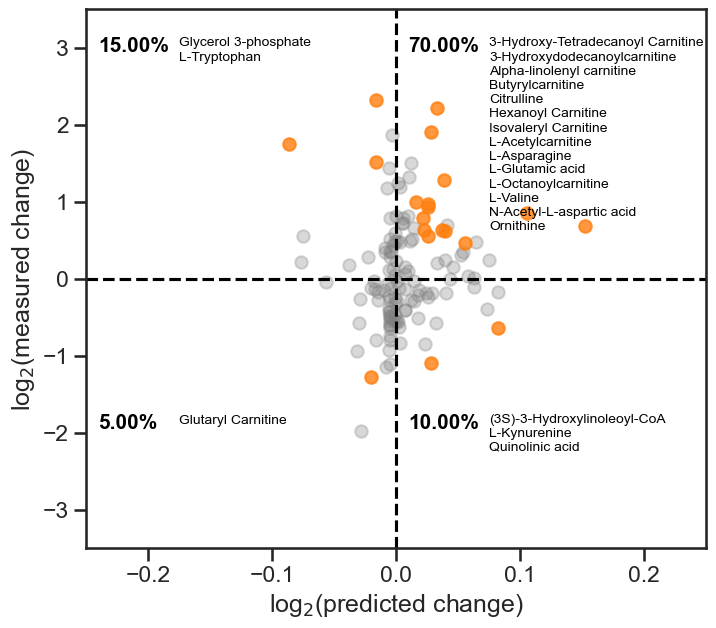

In [22]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(x=np.log2(df[df.hue=='grey']['prediction_proteomics']), y=np.log2(df[df.hue=='grey']['metabolomics']), 
           c='grey', alpha=0.3)
ax.scatter(x=np.log2(df[df.hue!='grey']['prediction_proteomics']), y=np.log2(df[df.hue!='grey']['metabolomics']), 
           c='C1', alpha=0.8)
ax.axhline(y=0.0, c='k', ls='--')
ax.axvline(x=0.0, c='k', ls='--')
plt.xlim(-0.25, 0.25)
plt.ylim(-3.5, 3.5)
ax.set_xlabel('log$_2$(predicted change)')
ax.set_ylabel('log$_2$(measured change)')

# plot.add_percentage(df=df, ax=ax, colname='prediction_proteomics', colname2='metabolomics',
#                     show_sc_percentages=False, fsize=15,
#                     l=(0.1, 0.9), l2=(0.7, 0.9), l3=(0.1, 0.3), l4=(0.7, 0.3))
plot.add_percentage(df=df[df.hue!='grey'], ax=ax, colname2='prediction_proteomics', colname='metabolomics',
                    show_sc_percentages=False, fsize=15,
                    l=(0.02, 0.95), l2=(0.52, 0.95), l3=(0.02, 0.25), l4=(0.52, 0.25))
plot.add_metabolite_names1(df=df[df.hue!='grey'], ax=ax, colname='prediction_proteomics', colname2='metabolomics', 
                           fsize=10, l=(0.15, 0.95), l2=(0.65, 0.95), l3=(0.15, 0.25), l4=(0.65, 0.25),
                           )
fig.savefig('../../images/UC/UC_metabolomics_vs_proteomics_1.png', bbox_inches='tight', dpi=300)
fig.savefig('../../images/UC/UC_metabolomics_vs_proteomics_1.svg', bbox_inches='tight')


In [68]:
_df = df.loc[(df.p < 0.05)].drop(['p', 'control_coeff', 'hue'], axis=1).rename(columns={'metabolomics':'measured change', 'prediction_proteomics':'predicted change'})
_df.loc[(_df['predicted change'] > 1.0) & (_df['measured change'] > 1.0), 'quadrant'] = 'UR'
_df.loc[(_df['predicted change'] < 1.0) & (_df['measured change'] > 1.0), 'quadrant'] = 'UL'
_df.loc[(_df['predicted change'] < 1.0) & (_df['measured change'] < 1.0), 'quadrant'] = 'LL'
_df.loc[(_df['predicted change'] > 1.0) & (_df['measured change'] < 1.0), 'quadrant'] = 'LR'
_df #= _df.merge(mets, left_on=_df.index, right_on='metabolite').set_index('metabolite')
# _df#.reset_index().to_excel('../manuscript/results_uc_patients.xlsx', index=False)

,predicted change,measured change,coverage,quadrant
metabolites,,,,
(3S)-3-Hydroxylinoleoyl-CoA,0.947074,3.351983,0.714286,upper left
1-Arachidonoyl-Sn-Glycero-3-Phosphoethanolamine,1.003382,1.389283,0.000000,upper right
"1-Dihomo-Linolenoylglycerophosphocholine (20:3, Delta 8, 11, 14), Lysopc A C20:3",0.996422,1.424532,0.062500,upper left
"1-Docosahexenoylglycerophosphocholine (Delta 4, 7, 10, 13, 16, 19), Sn1-Lpc (22:6)",0.996422,0.711163,0.062500,lower left
"1-Linoleoylglycerophosphocholine (Delta 9,12)",0.996422,0.572913,0.062500,lower left
"1-Octadeca-Trienoylglycerophosphocholine, Sn1-Lpc (18:3, Delta 9, 12, 15)",0.996422,0.657241,0.062500,lower left
1-Palmitoylglycerophosphocholine,0.996422,0.656247,0.062500,lower left
1-Palmitoylglycerophosphoethanolamine,1.003202,0.561005,0.000000,lower right
"1-Pentadecanoylglycerophosphocholine, Sn1-Lpc (15:0)",0.996422,0.682600,0.062500,lower left


In [71]:
_coverage = pd.read_excel('../../manuscript/results_uc_patients.xlsx')

In [74]:
model.gs.to_excel('../../manuscript/control_coefficients.xlsx')

<Axes: xlabel='number of rxns with gpr', ylabel='number of rxns with mapped gpr'>

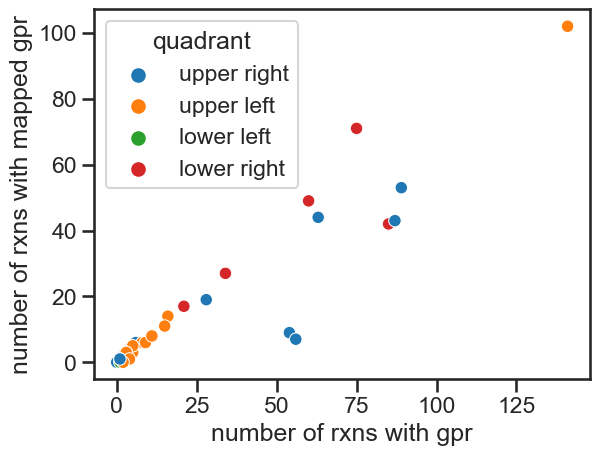

In [56]:
sns.scatterplot(data=_coverage, x='number of rxns with gpr', y='number of rxns with mapped gpr', hue='quadrant')
# _coverage.columns

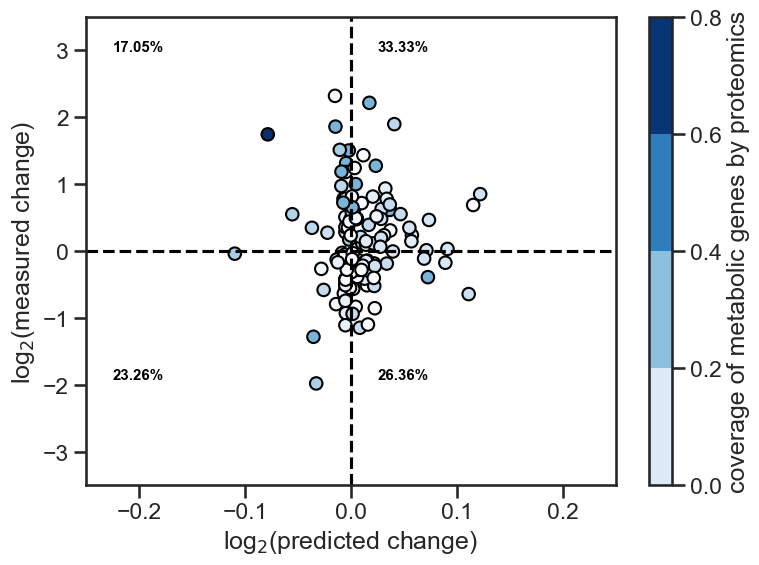

In [50]:
sns.set_context('talk')
sns.set_style('ticks')
# df = pd.concat((m2.groupby('metabolites').mean(), cc), axis=1).dropna()
# df = df.rename(columns={0: 'control_coeff'})
_df = df.copy()
# df = df[~df.index.str.contains("arnitine")]
_df = df.loc[(df.p < 0.05)]
_df = _df[(_df['metabolomics'] > 1.2) | (_df['metabolomics'] < 0.8)]
_df = _df[(_df['prediction_proteomics'] > 1.01) | (_df['prediction_proteomics'] < 0.99)]

plot.parity(data=_df, xcolumn='metabolomics', ycolumn='prediction_proteomics', cc=False, 
            figsize=(10, 8), save=True, filename='../../images/UC/parity_UC_patients_proteomics_158p.png',
            ylabel='log$_2$(measured change)', xlabel='log$_2$(predicted change)', color='C1',
            edgecolor=None,
            show_percentage=True, show_names=True, ub=0.8, lb=0.0, nb=5, cbar_cmap='Oranges',
            n=[1, 1, 1, 1], fsize=9, ylim=(-2.5, 2.5), xlim=(-0.25, 0.25), alpha=1.0,
            l_p=[(0.05, 0.95), (0.55, 0.95), (0.05, 0.25), (0.55, 0.25)],
            l_n=[(0.05, 0.9), (0.65, 0.95), (0.05, 0.2), (0.65, 0.25)]
            )

plot.parity(data=_df, xcolumn='metabolomics', ycolumn='prediction_proteomics', cc=True, cc_column='control_coeff', 
            figsize=(8, 7), save=True, filename='../../images/UC/parity_UC_patients_proteomics_158p_probability.png',
            ylabel='log$_2$(measured change)', xlabel='log$_2$(predicted change)', color='C1',
            show_percentage=True, show_names=True, ub=0.5, lb=0.0, nb=6, cbar_cmap='Reds',
            n=[1, 1, 1, 1], fsize=9, ylim=(-3.5, 3.5), xlim=(-0.25, 0.25), alpha=1.0,
            l_p=[(0.05, 0.95), (0.55, 0.95), (0.05, 0.25), (0.55, 0.25)],
            l_n=[(0.05, 0.9), (0.65, 0.95), (0.05, 0.2), (0.65, 0.25)]
            )

plot.parity(data=_df, xcolumn='metabolomics', ycolumn='prediction_proteomics', 
            cc=True, cc_column='coverage', cbar_label='coverage of metabolic genes by proteomics',
            figsize=(8, 6), save=True, filename='../../images/UC/parity_UC_patients_proteomics_158p_coverageProteomics.png',
            ylabel='log$_2$(measured change)', xlabel='log$_2$(predicted change)', color='C1',
            show_percentage=True, show_names=True, ub=0.8, lb=0.0, nb=5, cbar_cmap='Blues',
            n=[1, 1, 1, 1], fsize=9, ylim=(-3.5, 3.5), xlim=(-0.25, 0.25), alpha=1.0,
            l_p=[(0.05, 0.95), (0.55, 0.95), (0.05, 0.25), (0.55, 0.25)],
            l_n=[(0.05, 0.9), (0.65, 0.95), (0.05, 0.2), (0.65, 0.25)]
            )

In [ ]:
sns.set_context('talk')
for comp in m1.compartment.unique():
    df = pd.concat((m1[m1.compartment==comp].groupby('metabolites').mean(), cc), axis=1).dropna()
    df = df.rename(columns={0: 'control_coeff'})
    _df = df.loc[(df.p < 0.05)]
    _df = _df[(_df['metabolomics'] > 1.2) | (_df['metabolomics'] < 0.8)]
    _df = _df[(_df['prediction_proteomics'] > 1.02) | (_df['prediction_proteomics'] < 0.98)]
    if len(_df) > 0:
        if comp == 'cytoplasm':
            ftitle = 'cytoplasmic'
        else:
            ftitle = f'{comp}'
        plot.parity(data=_df, xcolumn='metabolomics', ycolumn='prediction_proteomics', cc=False, 
                figsize=(8, 6), save=True, filename=f'../images/UC/UC_metabolomics_vs_proteomics_{comp}.png',
                show_percentage=True, show_names=True, ub=0.4, lb=0.0,
                n=[1, 1, 1, 1], fsize=10, ylim=(-2.5, 2.5), xlim=(-0.25, 0.25),
                l_p=[(0.05, 0.95), (0.62, 0.95), (0.05, 0.25), (0.68, 0.25)],
                l_n=[(0.05, 0.9), (0.62, 0.9), (0.05, 0.2), (0.68, 0.2)],
                figtitle=ftitle)
    else:
        print(f'skipping {comp} as no metabolites are significant')
        print(f'{comp}: {len(_df)}')
   